In [1]:
from pathlib import Path
import pickle
import jax.numpy as jnp
import sys
sys.path.append('../')
from read_data import get_data, load_datasets
from jaxpm.nn import CNN
from jaxpm.painting import cic_paint, cic_read, compensate_cic
import yaml
from read_model import read_model
from jax.experimental.ode import odeint
from jaxpm.pm import make_ode_fn
import jax_cosmo as jc
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from jaxpm.pm import get_delta
from jaxpm.utils import power_spectrum
import numpy as np
plt.style.use(['science', 'vibrant'])

In [2]:
# reformat into functions and run
# add jit to whole train step
# hyper opt with wand
# add embedding net for time
# add option for time adding-diffusion like
# log potential loss at the end


# edge effects: check padding CNN boundary conditions, receptive field
# it looks like edge effects are gone, but the model with periodic boundaries is not training well
# check feature maps and potential plots
# do we need to accumulate gradients? -> Average over N sims
# add velocity loss
# Make sure periodicity is working and look at learned feature maps
# Look at potential plots and compare
# Make sure reading potential at right position when using boundaries
# Add test set to not fool
# If want to train on potential, remember to start from resolution factor!
# gradient clipping
# add option for added time embedding
# why is memory exploiding as function of nsims? it should only be loaded once
# improve scheduler, val loss platau?
# hyperparams opt, missing something

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [4]:
# plot feature maps

In [5]:
run_name = 'legendary-pyramid-162' #'magic-rain-161'

In [6]:
mesh_lr = 32
mesh_hr= 64
data_dir = Path(f"/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/data/matched_{mesh_lr}_{mesh_hr}/")
omega_c = 0.25
sigma8 = 0.8
cosmology = jc.Planck15(Omega_c=omega_c, sigma8=sigma8)

scale_factors = jnp.load(data_dir / f"scale_factors.npy")
snapshots = None
if snapshots is not None:
    scale_factors = scale_factors[snapshots]

_, val_data = load_datasets(
        1,
        1,
        mesh_hr=64,
        mesh_lr=32,
        data_dir=data_dir,
        snapshots=snapshots,
    )
data = val_data[0]

In [7]:

model_dir = Path(f'/n/holystore01/LABS/itc_lab/Users/ccuestalazaro/pm2nbody/models/{run_name}')

with open(model_dir / 'config.yaml') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)['correction_model']

neural_net, params = read_model(
    model_dir,
)

In [8]:
config

{'channels_hidden_dim': 16,
 'embed_globals': True,
 'globals_embedding_dim': 8,
 'input_dim': 2,
 'kernel_size': 3,
 'latent_size': 32,
 'n_convolutions': 3,
 'n_fully_connected': 2,
 'n_globals_embedding': 2,
 'n_knots': 16,
 'pad_periodic': True,
 'type': 'cnn'}

In [9]:
def get_prediction(
    params,
    pos_lr, 
    vel_lr,
    scale_factors,
):
    pos_pm, vel_pm = odeint(
        make_ode_fn(mesh_shape=(mesh_lr,mesh_lr,mesh_lr), 
                    add_correction=config['type'], 
                    model=neural_net),
        [pos_lr[0], vel_lr[0]],
        scale_factors,
        cosmology,
        params,
        rtol=1e-5,
        atol=1e-5,
    )
    return pos_pm, vel_pm



In [10]:
pos_pred, vel_pred = get_prediction(
    params,
    data['lr'].positions * mesh_lr,
    data['lr'].velocities * mesh_lr,
    scale_factors,

)

In [11]:
pos_pred /= mesh_lr

Text(0.5, 1.0, 'HR')

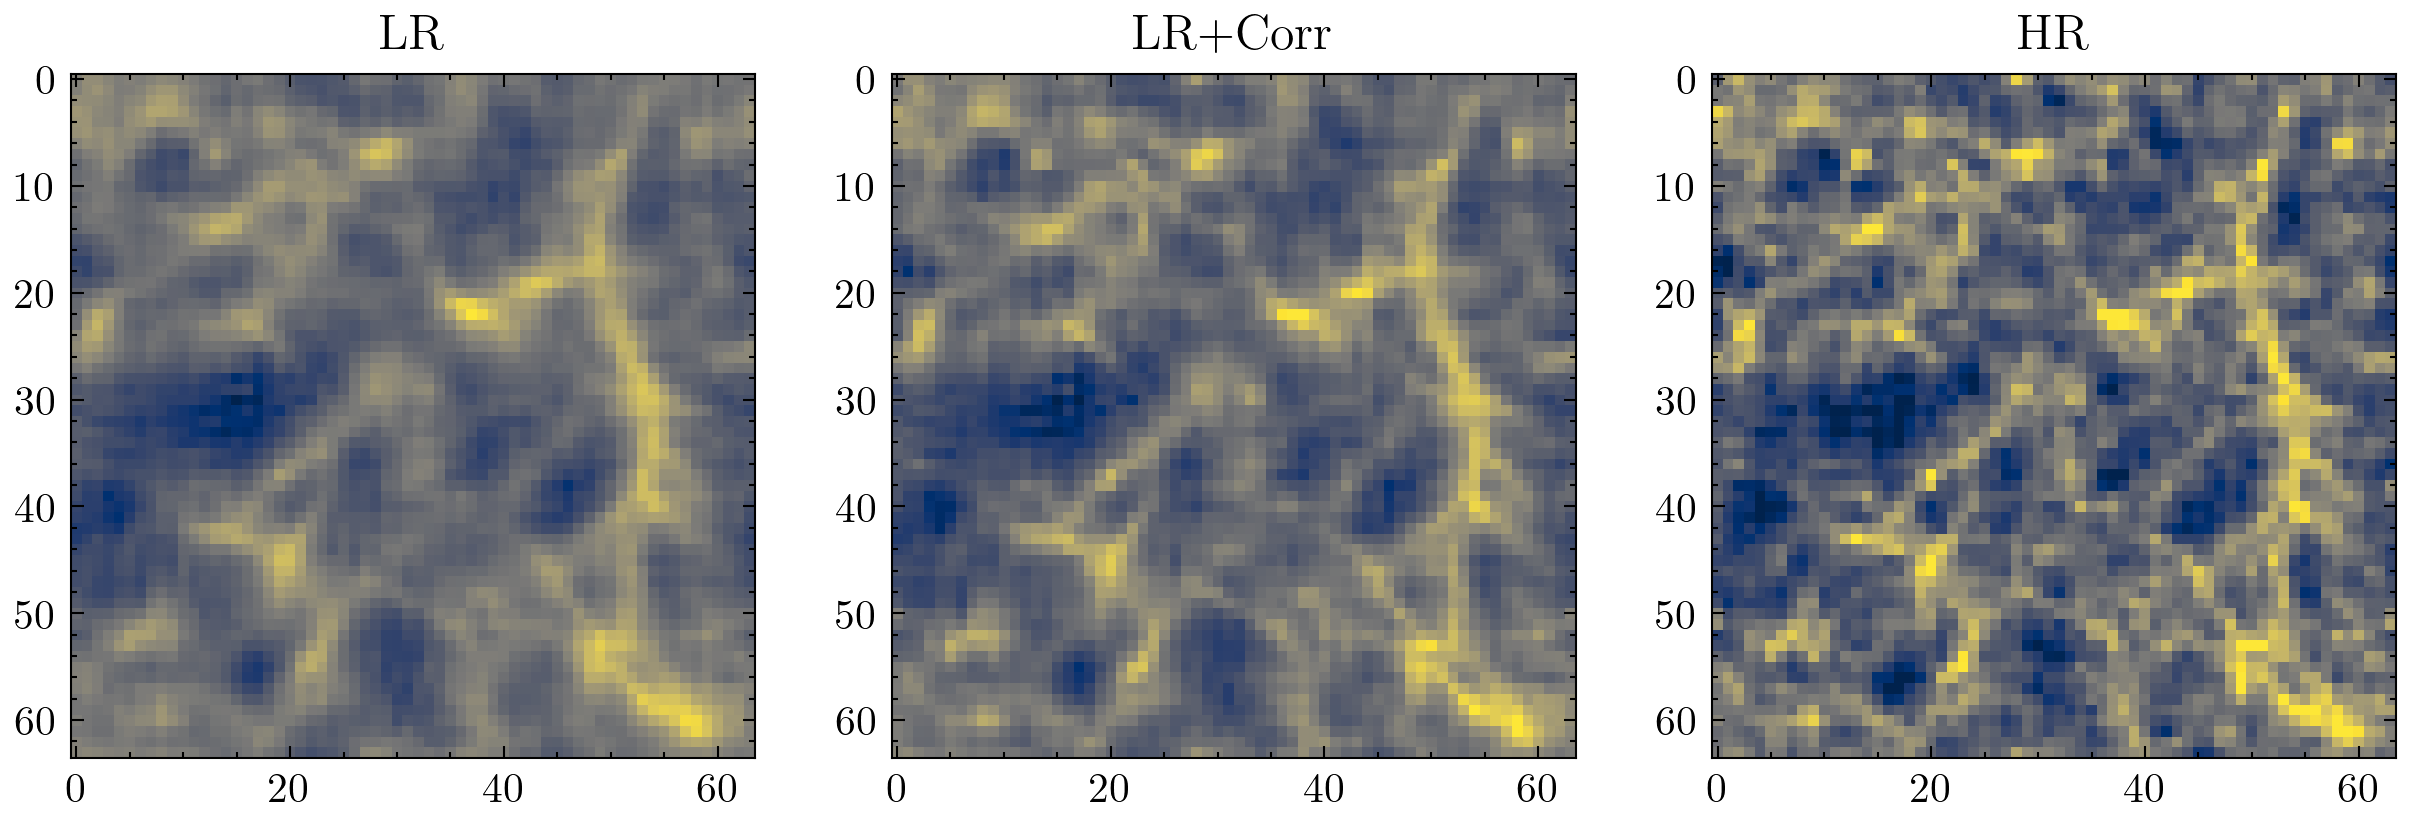

In [12]:

mesh_plot = 64
norm = LogNorm()#(vmin=0, vmax=150) 
cmap = 'cividis'

delta_hr = get_delta(data['hr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_lr = get_delta(data['lr'].positions[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))
delta_pred = get_delta(pos_pred[-1]*mesh_plot, (mesh_plot, mesh_plot, mesh_plot))


fig, ax = plt.subplots(ncols=3, figsize=(10, 5))
ax[0].imshow((delta_lr[:,:,:]).sum(axis=0),norm=norm, cmap=cmap)
ax[1].imshow((delta_pred[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)
ax[2].imshow((delta_hr[:,:,:]).sum(axis=0),norm=norm ,cmap=cmap)

ax[0].set_title("LR")
ax[1].set_title("LR+Corr")
ax[2].set_title("HR")

In [13]:
k, pk_lr = power_spectrum(
      compensate_cic(delta_lr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_pred = power_spectrum(
      compensate_cic(delta_pred),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

k, pk_hr = power_spectrum(
      compensate_cic(delta_hr),
      boxsize=np.array([256.] * 3),
      kmin=np.pi / 256.,
      dk=2 * np.pi / 256.)

/n/home11/ccuestalazaro/.local/lib/python3.10/site-packages/jax/_src/lax/lax.py:511: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


Text(0, 0.5, '$P(k)$')

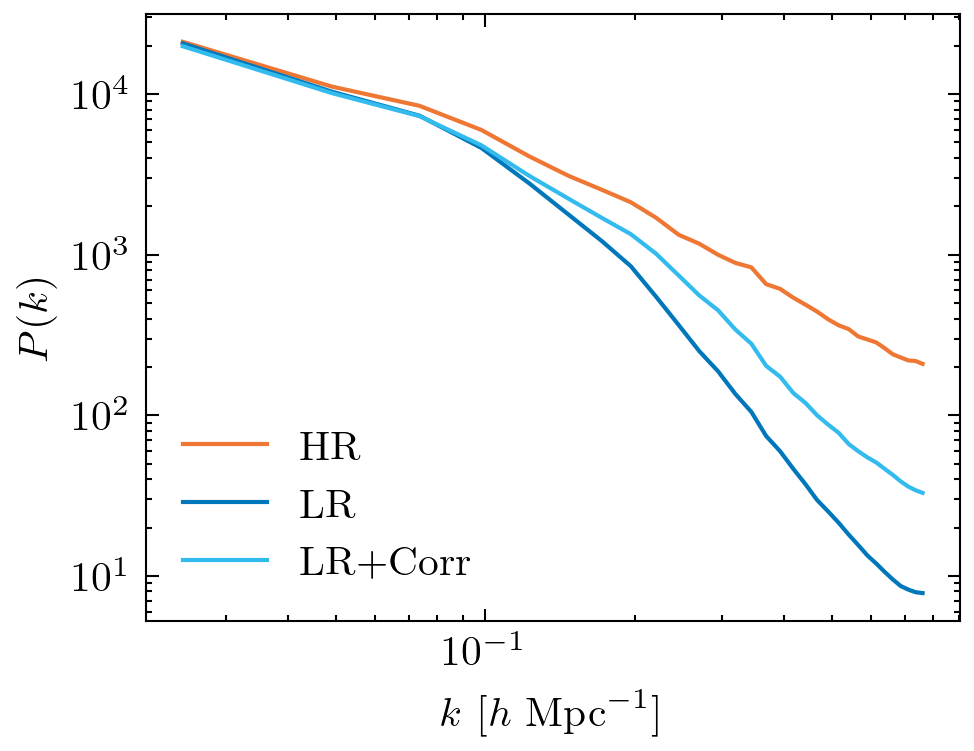

In [14]:
plt.loglog(k,pk_hr, label='HR')
c_lr = plt.loglog(k,pk_lr, label='LR')
c_pred = plt.loglog(k,pk_pred, label='LR+Corr')
plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)$")

Text(0, 0.5, '$P(k)/P_\\mathrm{HR}(k) - 1$')

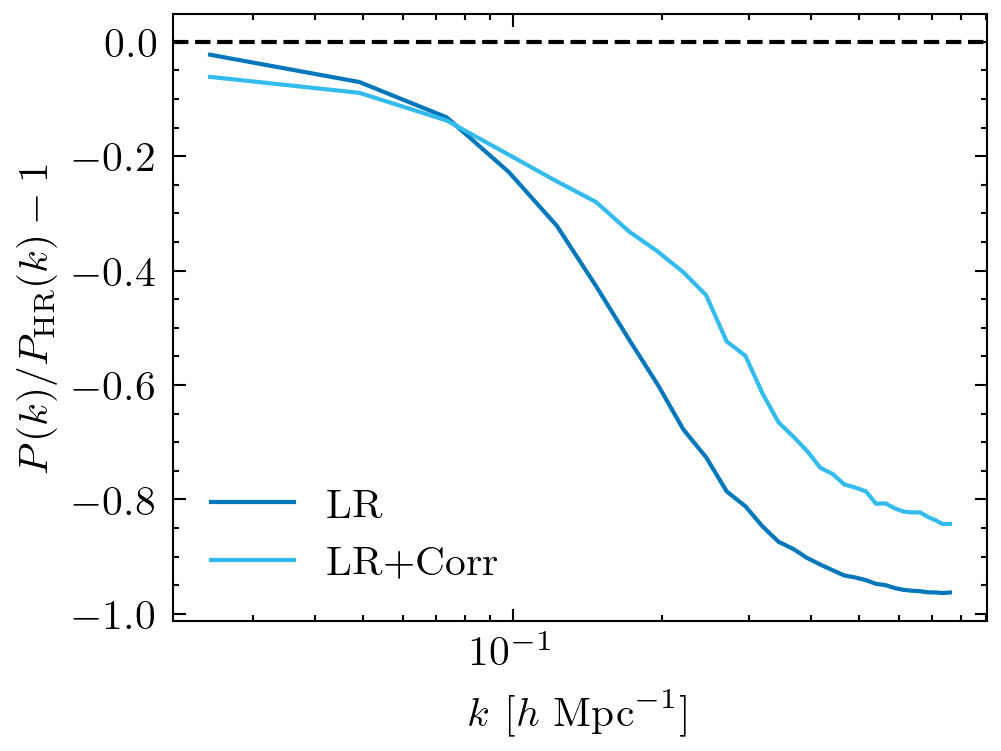

In [15]:
plt.axhline(y=0, linestyle='dashed', color='black')
plt.semilogx(k,pk_lr/pk_hr-1., label='LR', color=c_lr[0].get_color())
plt.semilogx(k,pk_pred/pk_hr-1., label='LR+Corr', color=c_pred[0].get_color())

plt.legend()
plt.xlabel(r"$k$ [$h \ \mathrm{Mpc}^{-1}$]")
plt.ylabel(r"$P(k)/P_\mathrm{HR}(k) - 1$")